In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from classy import Class
import scipy
import scipy.interpolate

# from nbodykit.lab import *
# from nbodykit import style, setup_logging

import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, interp2d
import math
import scipy.special as sp

import os
from time import time

In [2]:
Om_ref = 0.32
Ob_ref = 0.049
wDE_ref = -1.0
h_ref = 0.67
ns_ref = 0.96
As_ref = 2.1e-09
z_max_pk = 200        # highest redshift involved
k_per_decade = 35     # number of k values, controls final resolution
P_k_max_h_Mpc = 1.0   # this value is directly the maximum k value in the figure in Mpc

In [3]:
# Just standard LambdaCDM
cosmo_ref = Class()
cosmo_ref.set(
  {
    'output':'mPk',
    'Omega_cdm': Om_ref - Ob_ref,
    'Omega_b':Ob_ref,
    'h': h_ref,
    'Omega_Lambda': 0,
    'w0_fld':'-1.',
    'wa_fld': '0.',
    'A_s':As_ref,
    'n_s':ns_ref,
    'P_k_max_h/Mpc' : P_k_max_h_Mpc,
    'z_pk':'0.0, 1.0, 2.0',
    'evolver': 0,
  }
)
cosmo_ref.compute()

In [4]:
bg_ref = cosmo_ref.get_background()
z = bg_ref['z']
a = 1./(1.+z)
chi = bg_ref['comov. dist.']
z_of_chi = interp1d(chi, z)
chi_of_z = interp1d(z, chi)

In [5]:
wlog10a_vals = np.concatenate((np.array([-14, -3.5]), np.linspace(-3., 0, 8)))
w_vals       = np.concatenate((np.array([-1., -1.]),  np.random.uniform(-2, -0.5, 8)))

def as_class_str(l: list): return ','.join(map(str, l))
as_class_str(w_vals)

'-1.0,-1.0,-1.5296977038975919,-1.6516784244277871,-1.101288130710282,-1.8364307933118416,-0.626779638659611,-1.7571690472941262,-1.1548039271037083,-1.4435038200196906'

In [6]:
# Spline cosmology
cosmo_var = Class()
cosmo_var.set(
  {
    'output':'mPk',
    'Omega_Lambda': 0.,
    'Omega_fld': 0.,
    'Omega_wspl': -1,
    'Omega_b':Ob_ref,
    'Omega_cdm': Om_ref - Ob_ref,
    'use_ppf': 'yes',
    'A_s':As_ref,
    'n_s':ns_ref,
    'wlog10a_vals': as_class_str(wlog10a_vals),
    'w_vals' : as_class_str(w_vals),
    'evolver': 0,
    'z_pk': '0., 0.5',
    'h': h_ref,
  }
)
cosmo_var.compute()
bg_var = cosmo_var.get_background()

# $c_{s}^{2} = A \times w(z) + B$

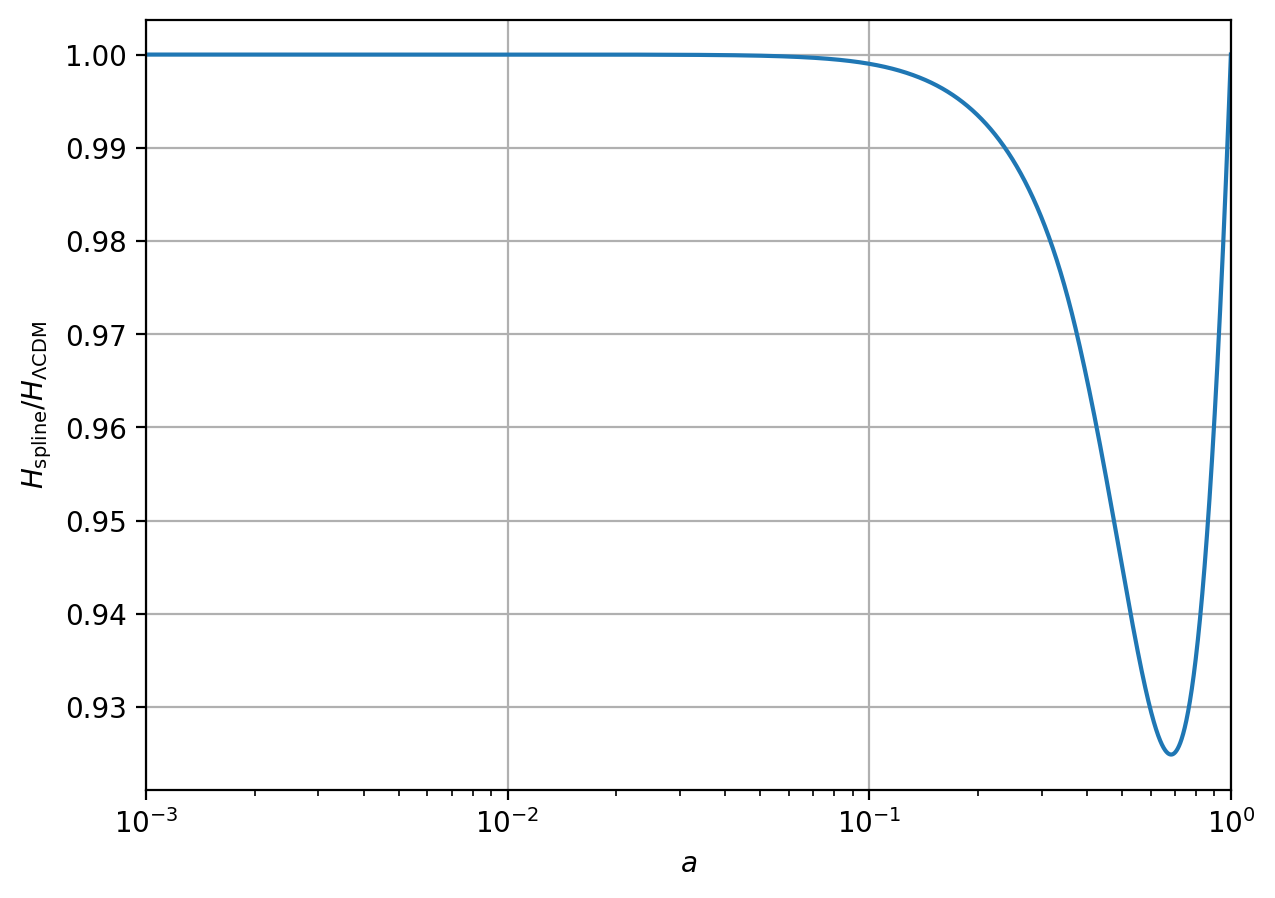

In [7]:
plt.figure(figsize=(7,5))
plt.semilogx(a, bg_var['H [1/Mpc]']/bg_ref['H [1/Mpc]'])
plt.xlabel(r"$a$")
plt.ylabel(r"$H_\mathrm{spline}/H_{\Lambda\mathrm{CDM}}$")
plt.xlim(1e-3, 1)
plt.grid()

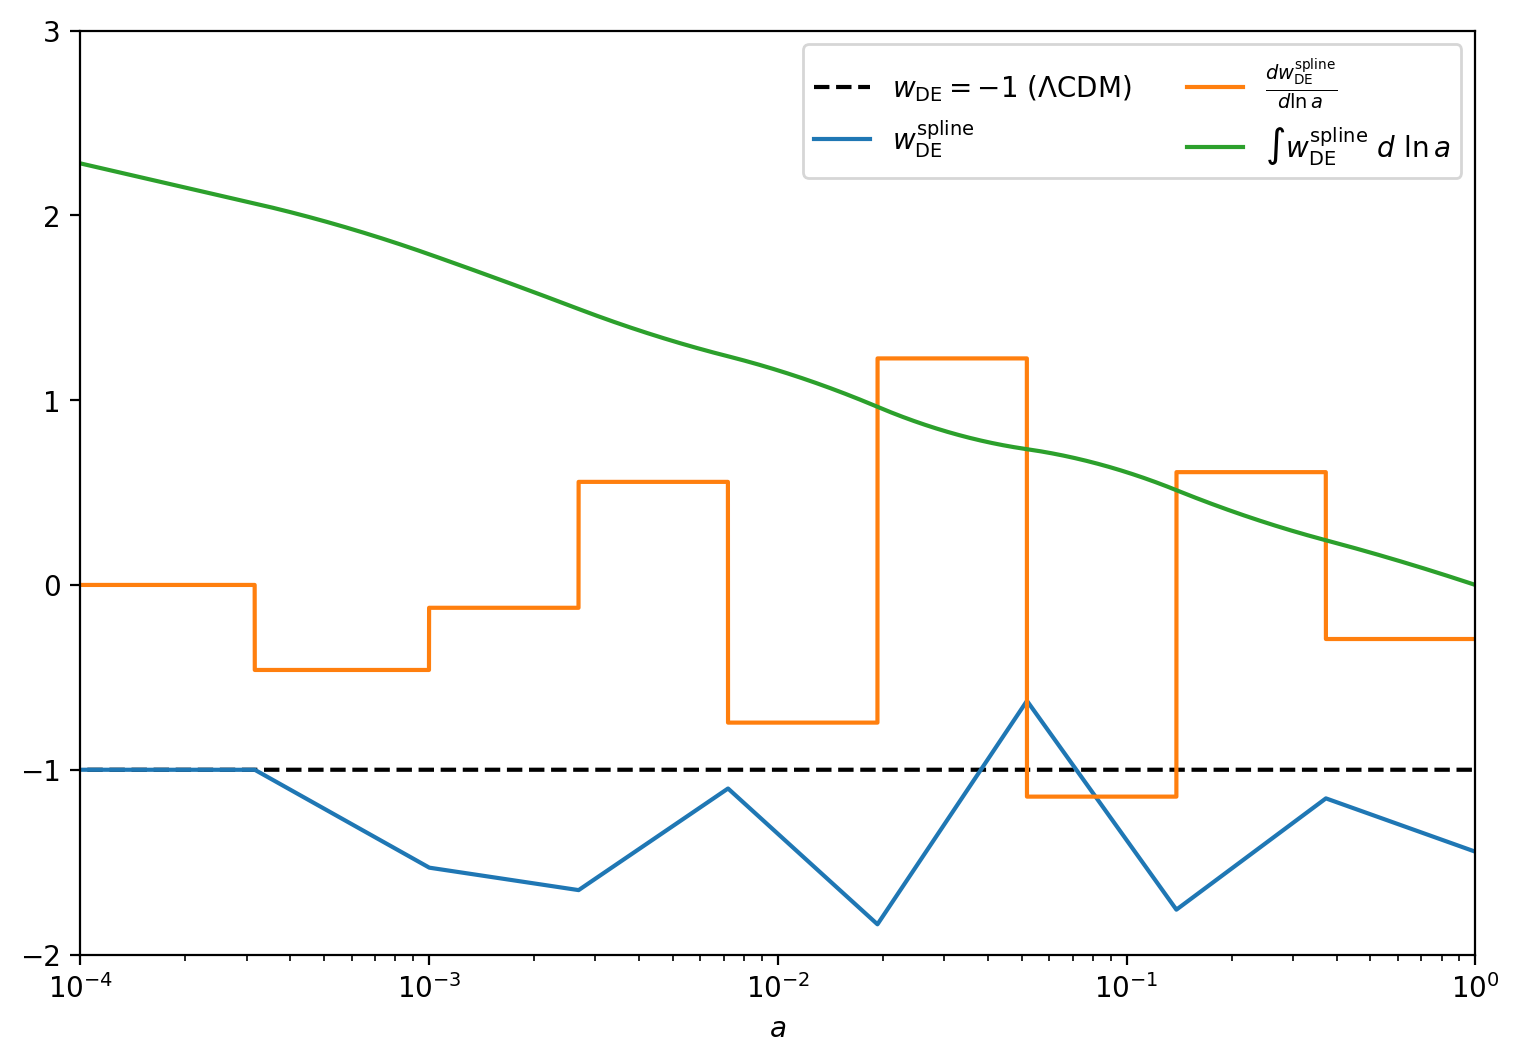

In [8]:
plt.figure(figsize=(9,6))

plt.semilogx(a, -1*np.ones_like(a), '--', color='black', label=r'$w_{\rm DE}=-1$ ($\Lambda$CDM)')
plt.semilogx(a, bg_var['wspl'], label=r'$w_{\rm DE}^{\rm spline}$')
plt.semilogx(a, bg_var['dwspl_dlna'], label=r'$\frac{d w_{\rm DE}^{\rm spline}}{d \ln a}$')
plt.semilogx(a, bg_var['int_wspl_dlna'], label=r'$\int w^{\rm spline}_{\rm DE}~ d~ \ln a$')
plt.xlim(1e-4, 1)
plt.ylim(-2, 3)
plt.xlabel(r'$a$')
plt.legend(ncol=2)

#plt.grid()

In [9]:
kk = np.logspace(-3, 0, 200) # k in h/Mpc

def pk_h_Mpc_inv(cosmo, k, z):
    h = cosmo.h()
    return cosmo.pk(k*h, z)*h**3
Pk_0  = np.array([pk_h_Mpc_inv(cosmo_var, k, 0) for k in kk])
Pk_0_lcdm  = np.array([pk_h_Mpc_inv(cosmo_ref, k, 0) for k in kk])
Pk_05 = np.array([pk_h_Mpc_inv(cosmo_var, k, 0.5) for k in kk])

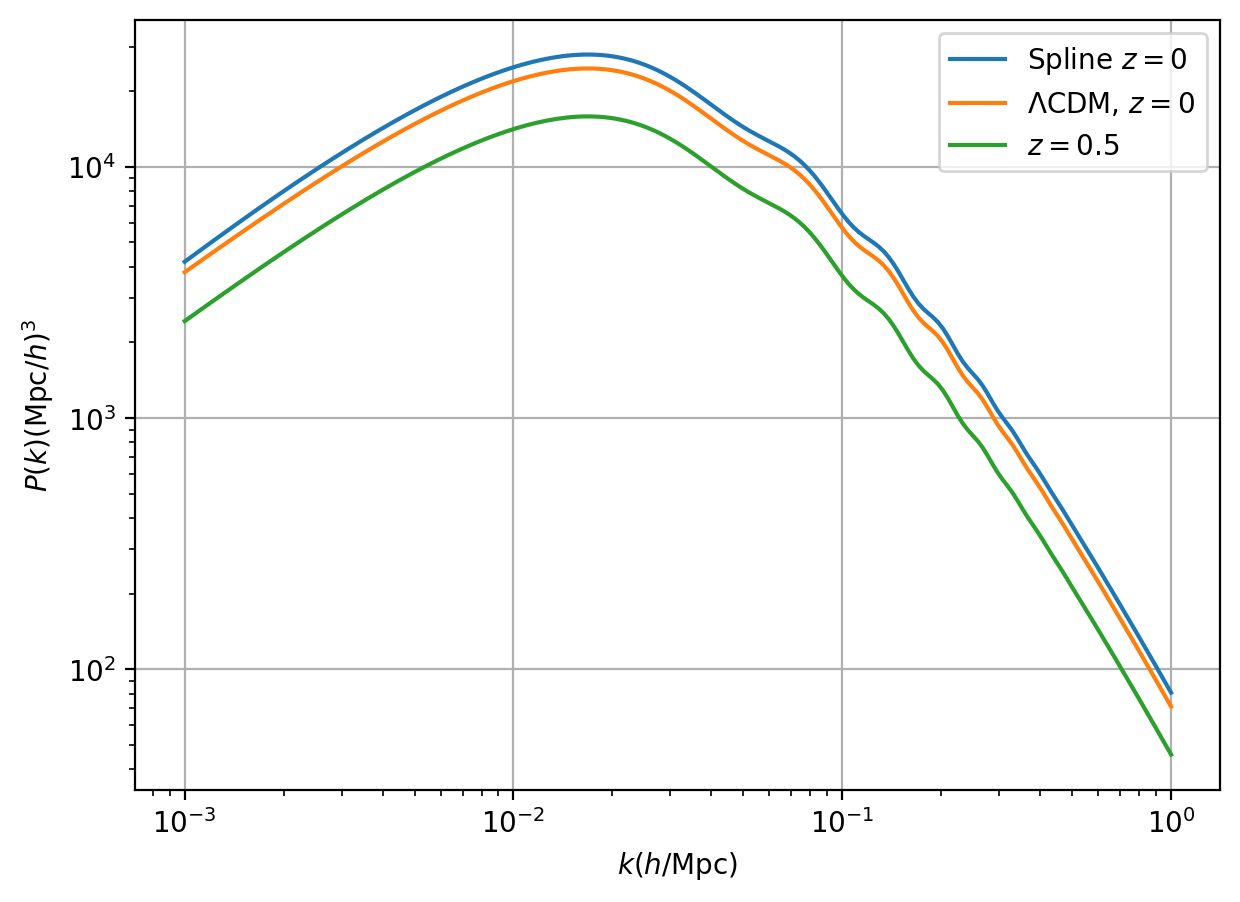

In [10]:
plt.figure(figsize=(7,5))
plt.loglog(kk, Pk_0,  label=r"Spline $z = 0$")
plt.loglog(kk, Pk_0_lcdm,  label=r"$\Lambda$CDM, $z = 0$")
plt.loglog(kk, Pk_05, label=r"$z = 0.5$")
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P(k) (\mathrm{Mpc}/h)^3$")
plt.legend()
plt.grid()

In [12]:
# Now with cs2 relations
cosmo_var2 = Class()
cosmo_var2.set(
  {
    'output':'mPk',
    'h': h_ref,
    'Omega_b':Ob_ref,
    'Omega_cdm': Om_ref - Ob_ref,
    'Omega_Lambda': 0.,
    'Omega_fld': 0.,
    'Omega_wspl': -1,
    'wlog10a_vals': as_class_str(wlog10a_vals),
    'w_vals' : as_class_str(w_vals),
    'cs2_0': -0.4,
    'cs2_1': 0.2,
    'use_ppf': 'yes',
    'A_s':As_ref,
    'n_s':ns_ref,
    'evolver': 0,
  }
)
cosmo_var2.compute()
bg_var2 = cosmo_var2.get_background()

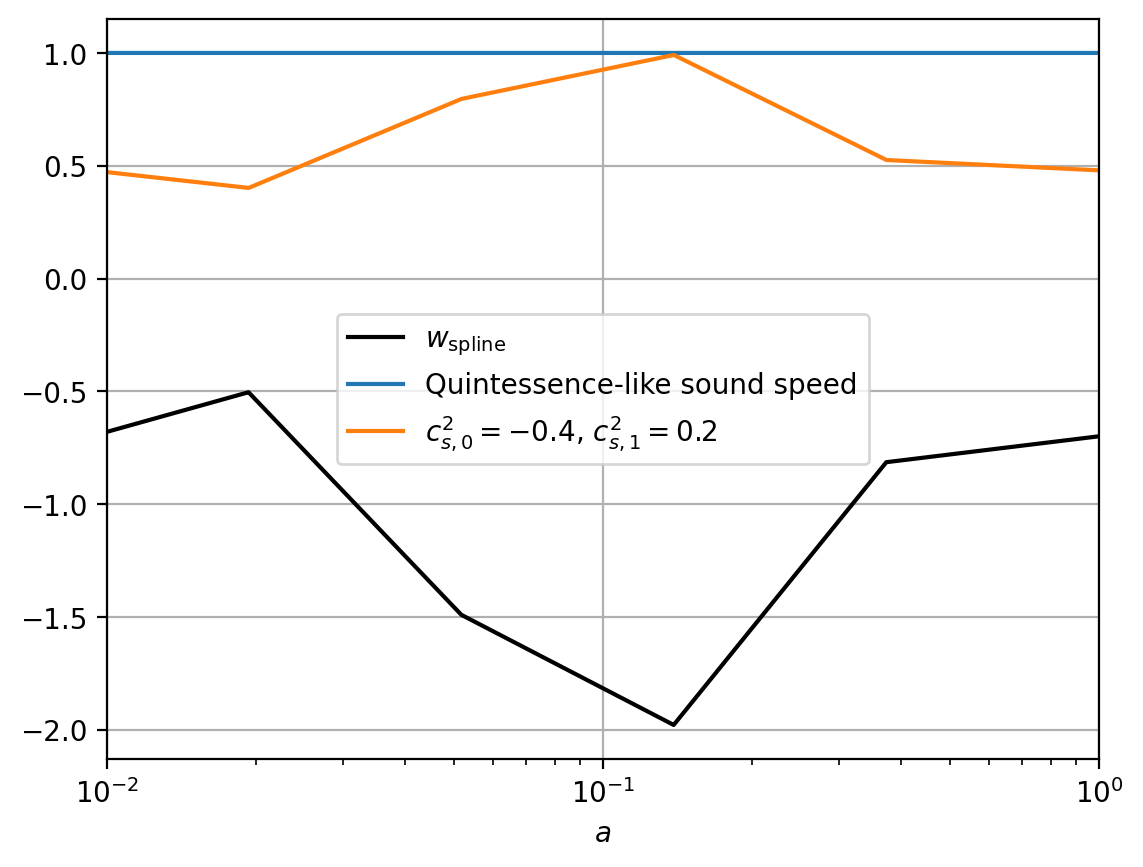

In [13]:
plt.semilogx(a, bg_var['wspl'], color='k', label=r"$w_\mathrm{spline}$")
plt.semilogx(a, bg_var['cs2_wspl'], label="Quintessence-like sound speed")
plt.semilogx(a, bg_var2['cs2_wspl'], label=r"$c^2_{s,0} = -0.4$, $c^2_{s,1} = 0.2$")

plt.xlim(1e-2, 1)
plt.xlabel(r"$a$")
plt.legend()
plt.grid()

In [216]:
# w0wa with cs2 relations
cosmo_var3 = Class()
cosmo_var3.set(
  {
    'output':'mPk, dTk, vTk',
    'Omega_Lambda': 0,
    'w0_fld': '-0.8',
    'wa_fld': '-0.1',
    'use_ppf': 'no',
    'cs2_fld_0': 1.0,
    'cs2_fld_1': 0.0,
    'A_s':As_ref,
    'n_s':ns_ref,
    'P_k_max_h/Mpc' : P_k_max_h_Mpc,
    'z_pk':'0.0, 1.0, 2.0',
    'evolver': 0,
    'h': h_ref,
    'Omega_b':Ob_ref,
    'Omega_cdm': Om_ref - Ob_ref
  }
)
cosmo_var3.compute()
bg_var3 = cosmo_var3.get_background()

5.541222106843528


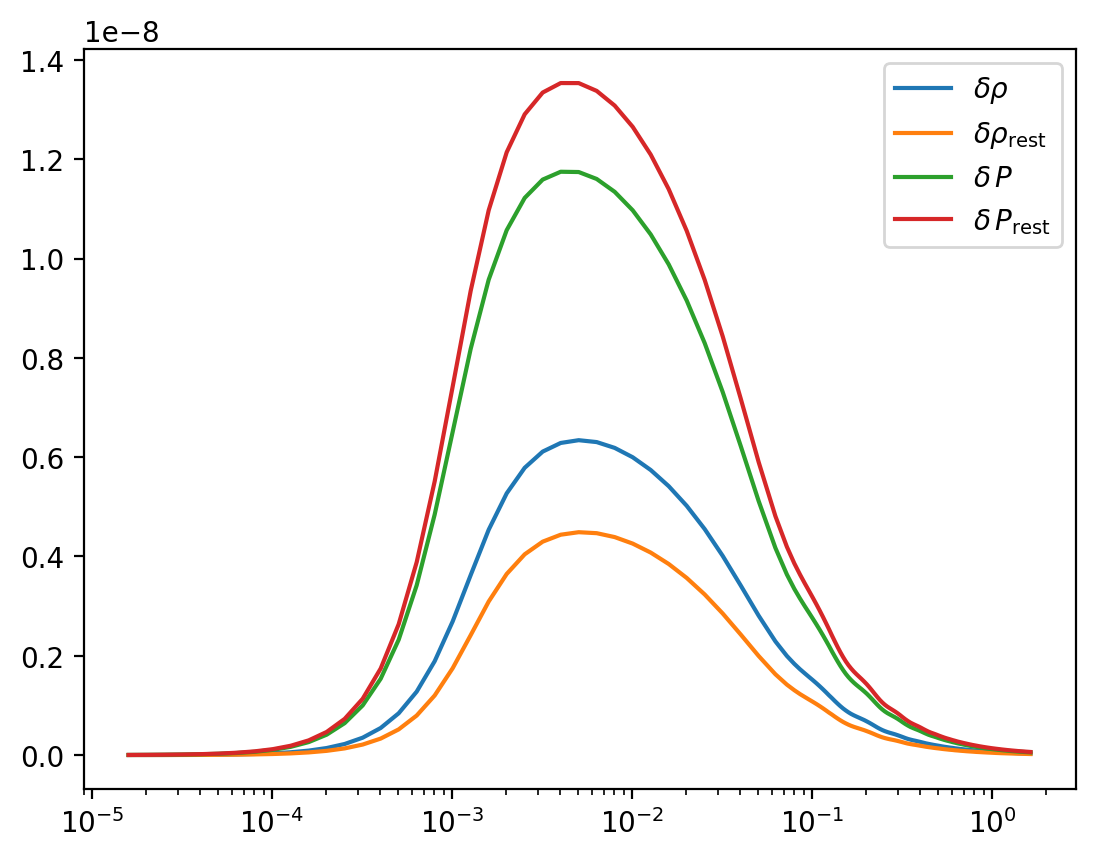

In [ ]:
def get_cs2_rest(cosmo, w0, wa):
    bg = cosmo.get_background()

    mask = bg['z'] < 3
    z = bg['z'][mask]
    a = 1/(z + 1)
    H = bg['H [1/Mpc]'][mask]
    rho_fld = bg['(.)rho_fld'][mask]
    w = w0 + wa*(1-a)
    ca2 = w + a*wa/(1 + w)/3
    
    for z_, a_, H_, w_, ca2_, rho_fld_ in zip(z, a, H, w, ca2, rho_fld):
        transfers = cosmo.get_transfer(z_)
        k         = transfers['k (h/Mpc)']
        k         = k/h_ref # convert to 1/Mpc
        d_rho_fld = transfers['d_rho_fld']
        d_p_fld   = -transfers['d_p_fld']
        d_fld     = transfers['d_fld']
        t_fld     = transfers['t_fld']

        d_fld_rest = d_fld + 3*a_*H_*(1 + w_)*t_fld/k**2
        d_rho_fld_rest = rho_fld_*d_fld_rest
        p_gamma    = d_p_fld - ca2_*d_rho_fld

        d_p_fld_rest = p_gamma + ca2_*rho_fld_*d_fld_rest
        cs2_rest = d_p_fld_rest / d_rho_fld_rest
    
    return cs2_rest, z, k, d_rho_fld, d_rho_fld_rest, d_p_fld, d_p_fld_rest

cs2_rest, z, k, d_rho_fld, d_rho_fld_rest, d_p_fld, d_p_fld_rest = get_cs2_rest(cosmo_var3, -0.8, -0.1)
plt.semilogx(k, d_rho_fld, label=r"$\delta\rho$")
plt.semilogx(k, d_rho_fld_rest, label=r"$\delta\rho_\mathrm{rest}$")
plt.semilogx(k, d_p_fld, label=r"$\delta \, P$")
plt.semilogx(k, d_p_fld_rest, label=r"$\delta \, P_\mathrm{rest}$")
plt.legend()

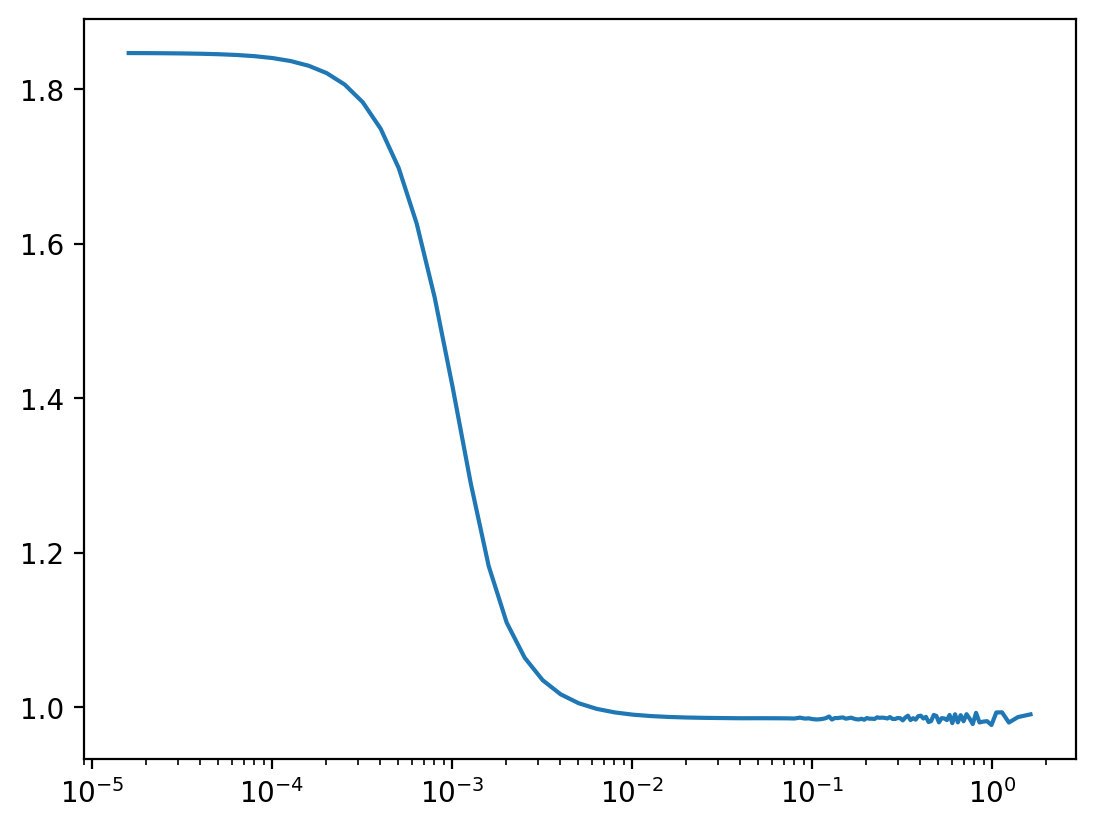

In [ ]:
plt.semilogx(k, cs2_rest, label=r"$\delta \, P_\mathrm{rest}$")

0.5730188691413166

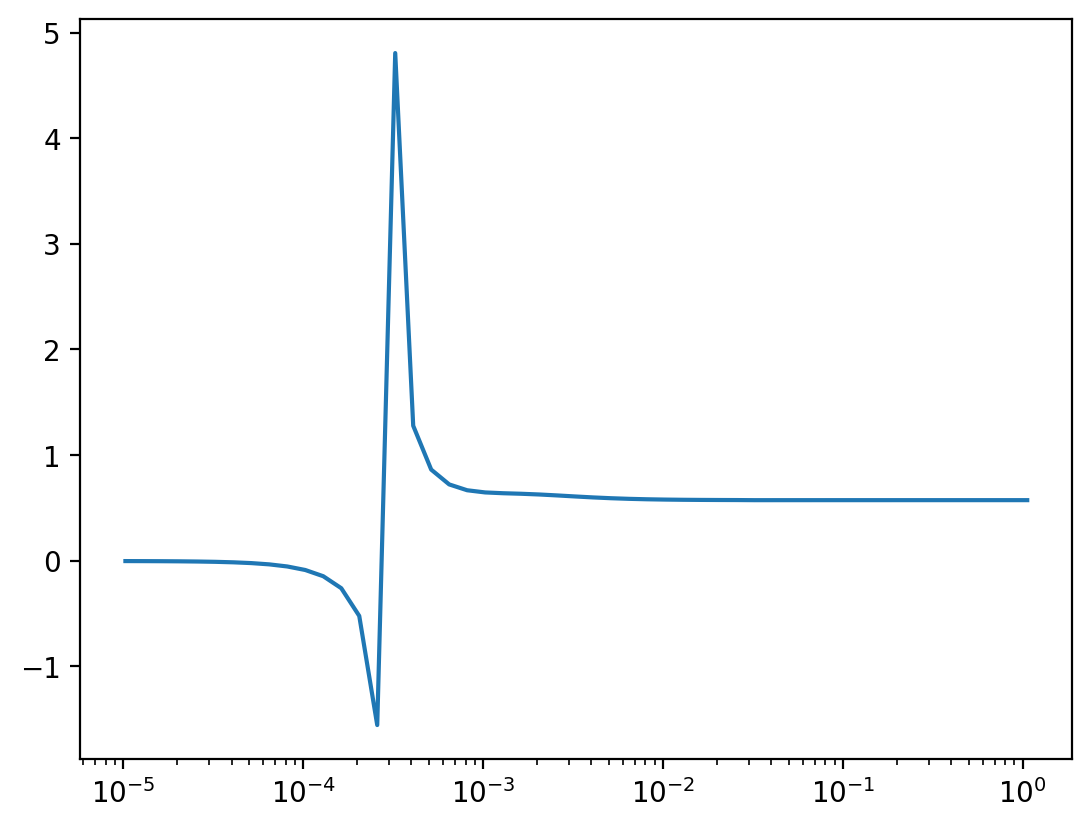

In [157]:
plt.semilogx(k, cs2_rest)
cs2_rest[-1]

array([  1.90657685,   1.90770884,   1.90950291,   1.91234624,
         1.91685244,   1.92399384,   1.93531109,   1.953245  ,
         1.98166168,   2.02668311,   2.09800018,   2.21094875,
         2.38980228,   2.67305083,   3.12213229,   3.8369949 ,
         4.98824873,   6.90035849,  10.3358522 ,  17.90888077,
        50.52918551, -66.97745496, -19.36202216, -10.91524241,
        -7.54502466,  -5.88276599,  -4.98250703,  -4.46772516,
        -4.16275092,  -3.97787959,  -3.86441279,  -3.79369413,
        -3.74950707,  -3.72178742,  -3.70433674,  -3.67677588,
        -3.67600379,  -3.67564908,  -3.67550491,  -3.67542369,
        -3.67536989,  -3.67532835,  -3.67529009,  -3.6752523 ,
        -3.675212  ,  -3.67517155,  -3.67512859,  -3.67508602,
        -3.67504188,  -3.67499935,  -3.6749575 ,  -3.6749226 ,
        -3.67489673,  -3.67488037,  -3.67486857,  -3.67487065,
        -3.6748777 ,  -3.67488952,  -3.6749023 ,  -3.674911  ,
        -3.67491508,  -3.67491077,  -3.6748972 ,  -3.67

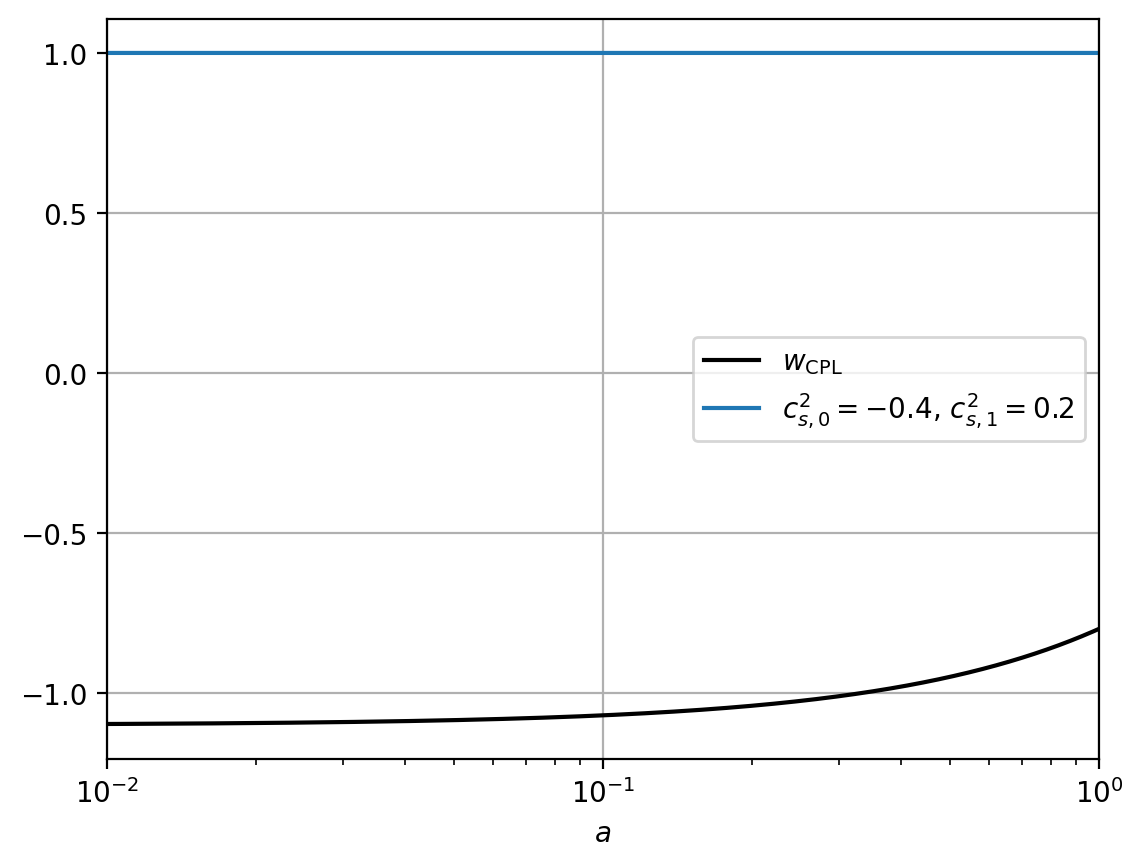

In [16]:
plt.semilogx(a, bg_var3['(.)w_fld'], color='k', label=r"$w_\mathrm{CPL}$")
plt.semilogx(a, bg_var3['cs2_fld'], label=r"$c^2_{s,0} = -0.4$, $c^2_{s,1} = 0.2$")

plt.xlim(1e-2, 1)
plt.xlabel(r"$a$")
plt.legend()
plt.grid()

In [16]:
print(bg_var3.keys())

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_fld', '(.)w_fld', 'cs2_fld', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


## Reproducing Rachel Bean's Plots
https://arxiv.org/pdf/astro-ph/0307100

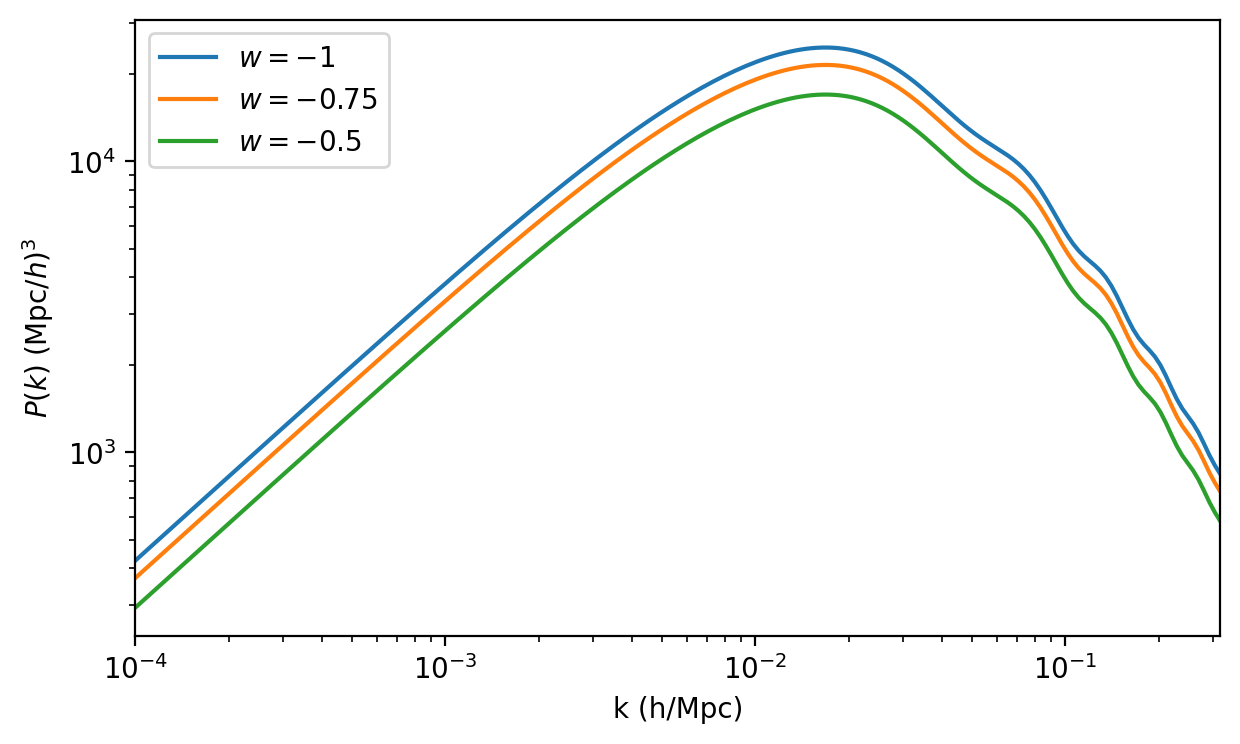

In [ ]:
kk = np.logspace(-4, -0.5, 200)
plt.figure(figsize=(7, 4))
for w in [-1, -0.75, -0.5]:
  cosmo = Class()
  w_vals = w*np.ones_like(wlog10a_vals)
  cosmo.set(
    {
      'output':'mPk',
      'h': h_ref,
      'Omega_b':Ob_ref,
      'Omega_cdm': Om_ref - Ob_ref,
      'Omega_Lambda': 0.,
      'Omega_fld': 0.,
      'Omega_wspl': -1,
      'wlog10a_vals': as_class_str(wlog10a_vals),
      'w_vals' : as_class_str(w_vals),
      'cs2_0': 0.0,
      'cs2_1': 0.0,
      'use_ppf': 'yes',
      'A_s':As_ref,
      'n_s':ns_ref,
      'evolver': 0,
    }
  )
  cosmo.compute()
  bg = cosmo.get_background()
  Pk  = np.array([pk_h_Mpc_inv(cosmo, k, 0) for k in kk])
  plt.loglog(kk, Pk, label=rf"$w = {w}$")
plt.xlim(kk[0], kk[-1])
plt.xlabel("k (h/Mpc)")
plt.ylabel(r"$P(k) \; (\mathrm{Mpc}/h)^3$")
plt.legend()